# Data & Env Initialization

In [1]:
import os, sys, gc

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from tqdm import tqdm

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, SequentialSampler
from torchvision import transforms, utils

import math
import multiprocessing as mp

data_path = "./input/3dmaskdata/"
data_path_dev = "./input/3dmaskdatadev/"

if not path.exists("input/"):
    with zipfile.ZipFile("input.zip", 'r') as zip_ref:
        zip_ref.extractall(".")

bin_mask_np = np.load(data_path + 'bin_mask_np.npy', mmap_mode='r')
bin_mask_np_dev = np.load(data_path_dev + 'bin_mask_np.npy', mmap_mode='r')

bin_mask_z_np = np.load(data_path + 'bin_mask_np.npy', mmap_mode='r')
bin_mask_z_np_dev = np.load(data_path_dev+'bin_mask_np.npy', mmap_mode='r')

n_cpu = 0 # mp.cpu_count() # 

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(0)
torch.set_default_tensor_type('torch.FloatTensor')

df = pd.read_csv('./input/meta-data/train.csv')
n_cpu

0

In [2]:
df

,ImageId,PredictionString
0,ID_8a6e65317,16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1,ID_337ddc495,66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2,ID_a381bf4d0,43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3,ID_7c4a3e0aa,43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4,ID_8b510fad6,37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...
...,...,...
4257,ID_de17ab626,70 0.177583 -0.023215 -3.08003 -25.3682 7.5732...
4258,ID_5a669e211,12 0.23817 -3.12745 3.13929 -7.21988 3.09626 1...
4259,ID_aa6ffba0a,35 0.166437 -0.497963 -3.12063 12.6792 5.48256...
4260,ID_29454123f,70 0.14292 0.0290822 -3.12594 -3.42749 3.38674...


# Constants

In [3]:
INF = 1e3

IMG_SHAPE = (2710, 3384) # size of ApolloCar3D images
h_out, w_out = 128, 256 # size of model's output
MINz = 1e-2
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1.]], dtype=np.float32)
camera_matrix_inv = np.linalg.inv(camera_matrix)

# Data Viz & Utils

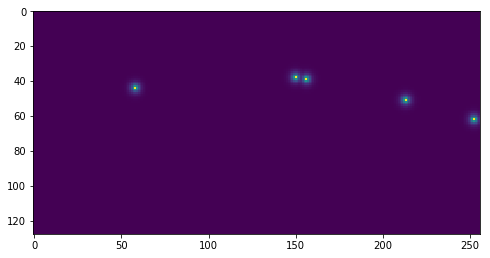

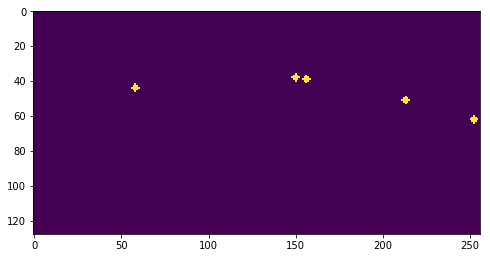

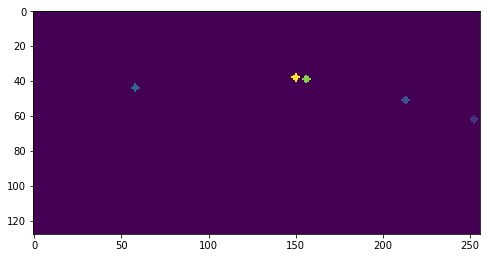

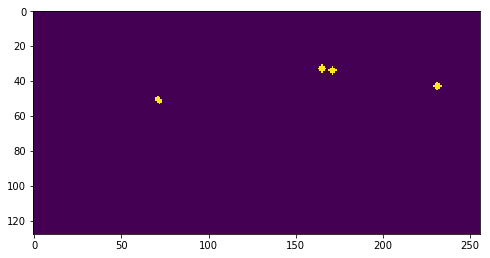

In [4]:
from math import sin, cos

def str2coords(s, names=['id', 'pitch', 'yaw', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

def get_img_coords(s, trans_x=0., trans_y=0.):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image
        ys: y coordinates in the image
    '''
    world_mat = np.eye(4)
    
    trans = np.array([trans_x, trans_y, 0.0])
    
    world_mat[:3, 3]  = trans
    world_mat[:3, :3] = np.array([[1.0, 0.0, 0.0], 
                              [0.0, 1.0, 0.0], 
                              [0.0, 0.0, 1.0]]).T
    world_mat = world_mat[:3, :]
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    
    hs = [1.0 for c in coords]
    P = np.array(list(zip(xs, ys, zs, hs))).T

    img_p = np.dot(camera_matrix, np.dot(world_mat, P)).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_cs = img_p[:, 0]
    img_rs = img_p[:, 1]
    
    img_zs = img_p[:, 2] # z = Distance from the camera
    
    return img_rs, img_cs, img_zs, coords

def _regr_preprocess(regr_dict, is_flip=False):
    regr_dict_co = dict()
    regr_dict_ag = dict()
    for name in ['x', 'y', 'z']:
        regr_dict_co[name] = regr_dict[name]
    regr_dict_ag['roll'] = regr_dict['roll']
    regr_dict_ag['pitch'] = regr_dict['pitch']
    regr_dict_ag['yaw'] = regr_dict['yaw']
    
    return regr_dict_co, regr_dict_ag

# https://www.kaggle.com/diegojohnson/centernet-objects-as-points
def get_heatmap(p_x, p_y, sigma=3.):
    X1 = np.linspace(1, w_out, w_out)
    Y1 = np.linspace(1, h_out, h_out)
    [X, Y] = np.meshgrid(X1, Y1)
    X = (X - p_x)*2.
    Y = (Y - p_y)*2.
    D2 = X * X + Y * Y
    E2 = sigma
    heatmap = np.exp(-np.sqrt(D2) / E2)
    return heatmap

def get_mask_and_regr(labels, is_heatmap=True):
    regr_names = ['x', 'y', 'z', 'pitch', 'yaw', 'roll']
    mask = np.zeros([h_out, w_out, 1], dtype='float16')
    bin_mask = np.zeros([h_out, w_out, 3], dtype='float16')
    regr_co_soft = np.zeros([h_out, w_out, 3], dtype='float16')
    regr_z = np.ones([h_out, w_out], dtype='float16') * INF
    if labels is not None:
        rs, cs, zs, coords = get_img_coords(labels)
    
        for r, c, z, regr_dict in zip(rs, cs, zs, coords):
            r = (r) * (h_out*2) / IMG_SHAPE[0] - h_out
            r = (r).astype('int')
            c = (c) * w_out / IMG_SHAPE[1]
            c = (c).astype('int')

            if (r >= 0) and (r < h_out) and (c >= 0) and (c < w_out):
                regr_dict_co, _ = _regr_preprocess(regr_dict, is_flip=False)
                regr_co_soft[r, c] = [regr_dict_co[n] for n in sorted(regr_dict_co)]

                if is_heatmap:
                    heatmap = get_heatmap(c, r)
                    mask[:,:,0] = np.maximum(mask[:,:,0],heatmap[:,:])
                    rows, cols = np.where(heatmap > 0.25)

                    for r0, c0 in zip(rows, cols):
                        if z < regr_z[r0, c0]:
                            regr_z[r0, c0] = z
                            regr_co_soft[r0, c0] = regr_co_soft[r, c]
                            bin_mask[r0,c0,:] = 1.
                else:
                    bin_mask[r, c,:] = 1.

    return mask, bin_mask, regr_co_soft

class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, dataframe, theta=[-0.517,0.303,-0.479], phi=-0.095, gamma=0.016, rho=0.073):
        self.df = dataframe
        self.theta = theta
        self.R = [[np.cos(phi),-np.sin(phi),0.],[np.sin(phi),np.cos(phi),0.],[0.,0.,1.]]
        self.Y = [[1.,0.,0.],[0.,np.cos(gamma),-np.sin(gamma)],[0.,np.sin(gamma),np.cos(gamma)]]
        self.P = [[np.cos(rho),0.,np.sin(rho)],[0.,1.,0.],[-np.sin(rho),0.,np.cos(rho)]]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        # Get image name
        im_code, labels = self.df.iloc[idx]
        # PART 2
        mask_soft_, bin_mask_, regr_co_soft_ = get_mask_and_regr(labels)
        mask_soft_ = np.rollaxis(mask_soft_, 2, 0)
        mask_soft = torch.from_numpy(mask_soft_).float()
        del mask_soft_
        
        rs, cs = np.where(bin_mask_[:,:,0]>0.)
        ys = (rs+h_out+.5) * IMG_SHAPE[0] / (h_out*2)
        xs = (cs+.5) * IMG_SHAPE[1] / w_out
        sky_labels = np.concatenate([np.reshape(xs,[-1,1])*regr_co_soft_[rs,cs,-1:],np.reshape(ys,[-1,1])*regr_co_soft_[rs,cs,-1:],regr_co_soft_[rs,cs,-1:]],axis=1)
        sky_label0 = np.dot(camera_matrix_inv, sky_labels.T).T
        sky_label0 = np.concatenate((np.zeros_like(sky_label0[:,:1]), np.zeros_like(sky_label0), sky_label0),axis=1)
        sky_label0 = np.reshape(sky_label0, [-1]).tolist()
        sky_label0 = ' '.join([str(elem) for elem in sky_label0])
        
        if len(sky_label0)==0:
            sky_label0 = None
        _, _, regr_co_soft_ = get_mask_and_regr(sky_label0, is_heatmap=False)
        
        R = np.reshape(np.array(self.R), [3,-1])
        P = np.reshape(np.array(self.P), [3,-1])
        Y = np.reshape(np.array(self.Y), [3,-1])
        # R = R / np.linalg.norm(R, axis=1, keepdims=True)
        
        sky_labels = np.matmul(np.matmul(np.matmul(np.dot(camera_matrix_inv, sky_labels.T).T, R.T), Y.T), P.T) + np.reshape(np.array(self.theta), [-1,3])
        sky_labels = np.concatenate((np.zeros_like(sky_labels[:,:1]), np.zeros_like(sky_labels), sky_labels),axis=1)
        sky_labels = sky_labels.tolist()
        sky_labels = ' '.join([' '.join([str(num) for num in (np.reshape(elem, [-1]).tolist())]) for elem in sky_labels if (elem[-1]>MINz)])
        
        if len(sky_labels)==0:
            sky_labels = None
        _, sky_bin_mask_, sky_regr_co_soft_ = get_mask_and_regr(sky_labels, is_heatmap=False)

        bin_mask_ = np.rollaxis(bin_mask_, 2, 0)
        bin_mask = torch.from_numpy(bin_mask_).float()
        
        regr_co_soft_ = np.rollaxis(regr_co_soft_, 2, 0)
        regr_co_soft = torch.from_numpy(regr_co_soft_).float()
        
        sky_bin_mask_ = np.rollaxis(sky_bin_mask_, 2, 0)
        sky_bin_mask = torch.from_numpy(sky_bin_mask_).float()
        
        sky_regr_co_soft_ = np.rollaxis(sky_regr_co_soft_[:,:,:1], 2, 0)
        sky_regr_co_soft = torch.from_numpy(sky_regr_co_soft_).float()
        
        del bin_mask_, regr_co_soft_, sky_bin_mask_, sky_regr_co_soft_
        
        mask_soft_, bin_mask_, regr_co_soft_, sky_bin_mask_, sky_regr_co_soft_ = None, None, None, None, None
        return [mask_soft, bin_mask, regr_co_soft, sky_bin_mask]

dataset = CarDataset(df)

mask_soft, bin_mask, regr_co_soft, sky_bin_mask = dataset[0]
mask_soft, bin_mask, regr_co_soft, sky_bin_mask = mask_soft.float(), bin_mask.float(), regr_co_soft.float(), sky_bin_mask.float()

plt.figure(figsize=(8,8))
plt.imshow(mask_soft.permute(1,2,0).numpy().squeeze())
plt.show()

plt.figure(figsize=(8,8))
plt.imshow((bin_mask.permute(1,2,0).numpy()[:,:,-1]).squeeze())
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(regr_co_soft.permute(1,2,0).numpy()[:,:,-1]/350.)
plt.show()

plt.figure(figsize=(8,8))
plt.imshow((sky_bin_mask.permute(1,2,0).numpy()[:,:,-1]).squeeze())
plt.show()

# Version

In [5]:
torch.__version__

'1.3.1+cu92'

In [6]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Dataset

In [7]:
dataset = CarDataset(df)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=0)

# Dataset Split

In [8]:
mask_soft, bin_mask, regr_co_soft, sky_bin_mask = None, None, None, None
for batch_idx, (mask_soft_batch, bin_mask_batch, regr_co_soft_batch, sky_bin_mask_batch) in enumerate(tqdm(train_loader)):
    rs, cs = np.where(bin_mask_batch[0,0,:,:] > 0.)
    indices = np.concatenate([np.reshape(rs,[-1,1]),np.reshape(cs,[-1,1])], axis=1)
    
    dat = (regr_co_soft_batch[0,:,:,:]).permute(1,2,0)[rs,cs,:]
    
    rs, cs = np.where(sky_bin_mask_batch[0,0,:,:] > 0.)
    output = np.concatenate([np.reshape(rs,[-1,1]),np.reshape(cs,[-1,1])], axis=1)

    np.save("Sky303/input_indices_{}.npy".format(batch_idx), indices)
    np.save("Sky303/input_data_{}.npy".format(batch_idx), dat.numpy())
    
    np.save("Sky303/output_indices_{}.npy".format(batch_idx), output)

100%|██████████████████████████████████████████████████████████████████████████████| 4262/4262 [02:26<00:00, 29.01it/s]
